In [95]:
from torch_geometric.transforms import ToUndirected
from torch.optim.lr_scheduler import ExponentialLR
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.nn import BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import uproot
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import awkward as ak
import random
random.seed(42)

In [2]:
uproot.__version__

'5.3.9'

In [3]:
file = uproot.open("/home/mxg1065/MyxAODAnalysis_super3D.outputs.root")

In [4]:
file.keys()

['analysis;1']

In [5]:
tree = file['analysis']
branches = tree.arrays()
type(branches)

awkward.highlevel.Array

In [6]:
print(tree.keys())  # variables per event

['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']


In [7]:
len(branches['cluster_to_cell_indices'][0])

839

# Preparing data with required features for 100 events

In [8]:
# Three arrays are awkward
# That that are not, are converted into np arrays
# (100, 187652) 100 events and 187652 cells
cell_coordinate_x = np.array(branches['cell_x'])
cell_coordinate_y = np.array(branches['cell_y'])  # (100, 187652)
cell_coordinate_z = np.array(branches['cell_z'])  # (100, 187652)
cell_eta = np.array(branches['cell_eta'])  # (100, 187652)
cell_phi = np.array(branches['cell_phi'])  # (100, 187652)
cell_subCalo = np.array(branches['cell_subCalo'])  # (100, 187652)
cell_sampling = np.array(branches['cell_sampling'])  # (100, 187652)
cell_weight = np.array(branches['cell_weight'])  # (100, 187652)
cell_truth = np.array(branches['cell_truth'])  # (100, 187652)
cell_to_cluster_e = np.array(branches['cell_to_cluster_e'])  # (100, 187652)
cell_noiseSigma = np.array(branches['cell_noiseSigma'])  # (100, 187652)
cell_SNR = np.array(branches['cell_SNR'])  # (100, 187652)
cell_time = np.array(branches['cell_time'])  # (100, 187652)
# 100 events but different number of entries per event
cellsNo_cluster = branches['cellsNo_cluster']
# Not a np array due to irregular subarray lengths
clustersNo_event = np.array(branches['clustersNo_event'])  # (100, 1)
cell_to_cluster_index = np.array(
    branches['cell_cluster_index'])  # (100, 187652)
cell_e = np.array(branches['cell_e'])  # (100, 187652)
# Not a np array due to irregular subarray lengths
cluster_to_cell_indices = branches['cluster_to_cell_indices']
# 100 events, but with different entries per event.
# Not a np array due to irregular subarray lengths
neighbor = branches['neighbor']
# 100 events but with a repeating pattern of
# [[63, 1, 26496, 26497, 26498, 26499, 64, 26751, 127, 26500, 65, 448], ...]...

In [ ]:
df = pd.DataFrame(
    data=[cell_SNR[0], cell_e[0], cell_noiseSigma[0]],
    index=['SNR', 'Energy', 'Noise']
)
df = df.T
df.head()

,SNR,Energy,Noise
0,0.576704,1153.415527,2000.014526
1,-0.292621,-585.246765,2000.014282
2,-1.002538,-2005.091553,2000.014526
3,-0.014552,-29.105059,2000.014771
4,-0.285134,-570.273132,2000.014526


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SNR,187652.0,0.140977,1.440538,-10.715983,-0.474518,0.023217,0.583733,246.443863
Energy,187652.0,80.177582,1016.051453,-14099.645508,-25.092455,0.981696,32.966190,62743.292969
Noise,187652.0,184.176025,827.457336,0.000000,28.157570,64.892403,108.025414,20616.970703


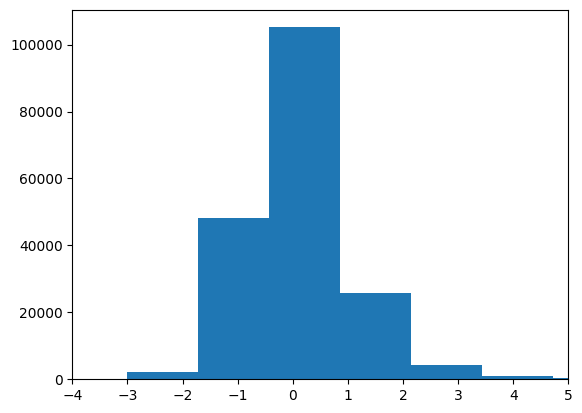

In [ ]:
_ = plt.hist(df.SNR, bins=200)
_ = plt.xlim(-4, 5)
plt.show()

In [12]:
df[df.Noise == 0]  # Find the cell indices that are broken (reporting 0 noise)

,SNR,Energy,Noise
186986,-1.0,0.0,0.0
187352,-1.0,0.0,0.0


# Preparing Neighbor Pairs

In [13]:
print(len(branches['neighbor']))  # 100 Events
# For each event, there are 187,652 lists containing the
print(len(branches['neighbor'][0]))
# cell neighbor IDs for each cell. For example, Cell 0's neighbors are:
# 63, 1, 26496, 26497, 26498, 26499, 64, 26751, 127, 26500, 65, 448
# as can be seen if we print neighbor[0]

100
187652


In [14]:
type(branches['neighbor'][0])

awkward.highlevel.Array

In [15]:
neighbor_relation_event0 = branches['neighbor'][0]
len(neighbor_relation_event0)  # Number of cells

187652

In [16]:
len(neighbor_relation_event0[0])

12

In [17]:
neighbor_relation_event0[0]  # ID of the cells neighboring cell 0

<Array [63, 1, 26496, 26497, 26498, ..., 127, 26500, 65, 448] type='12 * int32'>

In [18]:
type(neighbor_relation_event0)

awkward.highlevel.Array

In [19]:
broken_cells = np.argwhere(df.Noise == 0)
broken_cells = [int(i) for i in np.squeeze(broken_cells)]
print(type(broken_cells), broken_cells)

<class 'list'> [186986, 187352]


In [20]:
# Since we want to prepare the neighbor pairs, we need to use the
# branches['neighbor'][0] (first event) awkward array. However, we
# need to remove the broken cells.

neighbor_pairs_set = []
num_of_cells = len(neighbor_relation_event0)  # Number of cells: 187,652
# Loop through all cells and their respective neighbors
for i in range(num_of_cells):
    # Skip the iteration if the current cell is a broken cell
    if i in broken_cells:
        continue
    # Loop through each neighbor for the current cell
    for cell in neighbor_relation_event0[i]:
        # Skip the neighbor if cell is broken
        if cell in broken_cells:
            continue
        # Append the pair to the set
        neighbor_pairs_set.append((i, int(cell)))
# Loops through all cells in the neighbor list. If the loop reaches the cell number
# 186986 or 187352, loop skips over these inoperative cells. neibor_pairs_set.append((i,cell))
# adds a tuple of the current cell and its neighbor to the list.

In [ ]:
# Checking if the broken cells were in fact removed
found_broken_cells = []

# Loop through each pair of neighbors
for pair in neighbor_pairs_set:
    # Loop through each cell in pair
    for cell in pair:
        # If the cell is broken, appends to list
        if cell in broken_cells:
            found_broken_cells.append(cell)

if found_broken_cells:
    print("Error: Broken cells are still present in neighbor pairs.")
else:
    print("Successfully excluded broken cells.")

Successfully excluded broken cells.


In [22]:
neighbor_pairs_set[:15]

[(0, 63),
 (0, 1),
 (0, 26496),
 (0, 26497),
 (0, 26498),
 (0, 26499),
 (0, 64),
 (0, 26751),
 (0, 127),
 (0, 26500),
 (0, 65),
 (0, 448),
 (1, 0),
 (1, 2),
 (1, 26500)]

In [23]:
len(neighbor_pairs_set)

2500484

In [24]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS sorted based on the first element of each pair


In [25]:
# A code to remove permutation variant
def canonical_form(t):
    """Sorts elements of the tuple and converts the sorted list back into a tuple."""
    return tuple(sorted(t))


def remove_permutation_variants(tuple_list):
    """
    Creates a set of unique tuples by converting each tuple to its canonical form.
    Remove permutation variants from a list of tuples.
    Converts set back into a list of tuples.
    """
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    return [tuple(sorted(t)) for t in unique_tuples]

In [26]:
# remove list_of_tuples = [(3, 1), (1, 3), (2, 4), (4, 2), (5, 6)]
neighbor_pairs_set = remove_permutation_variants(neighbor_pairs_set)

In [27]:
len(neighbor_pairs_set)

1250242

In [28]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS NOT sorted based on the first element of each pair


In [29]:
neighbor_pairs_set = sorted(neighbor_pairs_set, key=lambda x: x[0])
# Sorts the unique neighbor pairs by the first element of each tuple

In [30]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS sorted based on the first element of each pair


In [31]:
neighbor_pairs_set = np.array(neighbor_pairs_set)
print(neighbor_pairs_set)
print(neighbor_pairs_set.shape)

[[     0  26751]
 [     0      1]
 [     0    127]
 ...
 [187648 187649]
 [187649 187650]
 [187650 187651]]
(1250242, 2)


## Creating Labels for neighbor_pairs

In [32]:
# Represents the cluster that each cell is associated with
cell_to_cluster_index

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 623,   0,   0],
       [996, 996, 996, ...,   0,   0,   0]], dtype=int32)

In [33]:
cell_to_cluster_index.shape

(100, 187652)

In [34]:
cluster_cells_belong_to_event0 = cell_to_cluster_index[0]
cluster_cells_belong_to_event0.shape

(187652,)

Labels for the neighbor pairs:
* True-True: 1
* Lone-Lone: 0
* Cluster-Lone: 2
* Lone-Cluster: 3
* Cluster-Cluster: 4

In [35]:
labels_for_neighbor_pairs = []
for pair in neighbor_pairs_set:
    # If the cells' cluster indices are the same
    if cluster_cells_belong_to_event0[pair[0]] == cluster_cells_belong_to_event0[pair[1]]:
        # And the cells are participating (cluster index is nonzero)
        if cluster_cells_belong_to_event0[pair[0]] != 0:
            # Label 1 - Both cells belong to the same
            labels_for_neighbor_pairs.append(1)
            # cluster (True-True)
        # And the cells are not participating
        else:
            # Label 0 - Both cells are not participating
            labels_for_neighbor_pairs.append(0)
            # So they are not part of a cluster (Lone-Lone)
    # If the cell's cluster indices are different
    else:
        # And both cells are participating
        if cluster_cells_belong_to_event0[pair[0]] != 0 and cluster_cells_belong_to_event0[pair[1]] != 0:
            # Label 4 - Both cells are from different
            labels_for_neighbor_pairs.append(4)
            # clusters (Cluster-Cluster)
        # And the first cell is non-participating while the second is participating
        elif cluster_cells_belong_to_event0[pair[0]] == 0 and cluster_cells_belong_to_event0[pair[1]] != 0:
            # Label 3 - The first cell is not in a cluster
            labels_for_neighbor_pairs.append(3)
            # while the second one is (Lone-Cluster)
        # And the first cell is participating while the second is non-participating
        else:
            # Label 2 - The first cell is in a cluster
            labels_for_neighbor_pairs.append(2)
            # while the second one is not (Cluster-Lone)

In [36]:
labels_for_neighbor_pairs = np.array(labels_for_neighbor_pairs)
print(labels_for_neighbor_pairs.shape)
print(labels_for_neighbor_pairs)
print(set(labels_for_neighbor_pairs))

(1250242,)
[0 0 0 ... 0 0 0]
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}


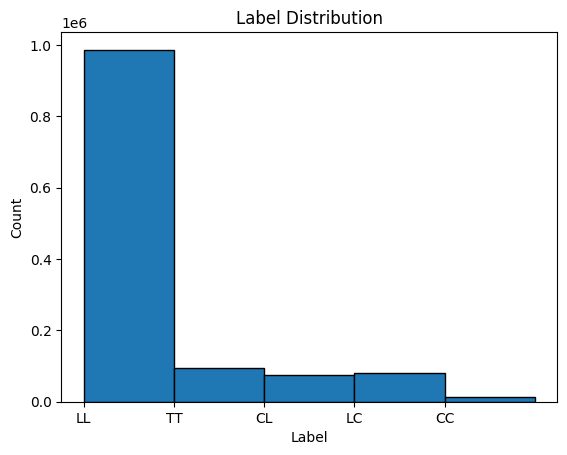

In [ ]:
# Histogram of label distribution
_ = plt.hist(labels_for_neighbor_pairs, bins=range(6), edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4], ['LL', 'TT', 'CL', 'LC', 'CC'])
plt.show()

# Preparing the Data for Multi-Class Classification

In [38]:
indices_for_tt_pairs = list(np.where(labels_for_neighbor_pairs == 1)[0])
indices_for_ll_pairs = list(np.where(labels_for_neighbor_pairs == 0)[0])
indices_for_cl_pairs = list(np.where(labels_for_neighbor_pairs == 2)[0])
indices_for_lc_pairs = list(np.where(labels_for_neighbor_pairs == 3)[0])
indices_for_cc_pairs = list(np.where(labels_for_neighbor_pairs == 4)[0])

In [39]:
# This prints the number of each type of pair in the 0th event
print(len(indices_for_tt_pairs))
print(len(indices_for_ll_pairs))
print(len(indices_for_cl_pairs))
print(len(indices_for_lc_pairs))
print(len(indices_for_cc_pairs))

95782
986490
75891
79248
12831


## Making training and testing sets

In [40]:
# Performing a 70-30 split of the indices of the pairs
sample_size_70tt = int(len(indices_for_tt_pairs) * 0.7)
sample_size_30tt = int(len(indices_for_tt_pairs) * 0.3)

sample_size_70ll = int(len(indices_for_ll_pairs) * 0.7)
sample_size_30ll = int(len(indices_for_ll_pairs) * 0.3)

sample_size_70cl = int(len(indices_for_cl_pairs) * 0.7)
sample_size_30cl = int(len(indices_for_cl_pairs) * 0.3)

sample_size_70lc = int(len(indices_for_lc_pairs) * 0.7)
sample_size_30lc = int(len(indices_for_lc_pairs) * 0.3)

sample_size_70cc = int(len(indices_for_cc_pairs) * 0.7)
sample_size_30cc = int(len(indices_for_cc_pairs) * 0.3)

indices_tt_pairs70 = np.random.choice(
    indices_for_tt_pairs, size=sample_size_70tt, replace=False)
indices_ll_pairs70 = np.random.choice(
    indices_for_ll_pairs, size=sample_size_70ll, replace=False)
indices_cl_pairs70 = np.random.choice(
    indices_for_cl_pairs, size=sample_size_70cl, replace=False)
indices_lc_pairs70 = np.random.choice(
    indices_for_lc_pairs, size=sample_size_70lc, replace=False)
indices_cc_pairs70 = np.random.choice(
    indices_for_cc_pairs, size=sample_size_70cc, replace=False)

indices_tt_pairs30 = np.random.choice(
    indices_for_tt_pairs, size=sample_size_30tt, replace=False)
indices_ll_pairs30 = np.random.choice(
    indices_for_ll_pairs, size=sample_size_30ll, replace=False)
indices_cl_pairs30 = np.random.choice(
    indices_for_cl_pairs, size=sample_size_30cl, replace=False)
indices_lc_pairs30 = np.random.choice(
    indices_for_lc_pairs, size=sample_size_30lc, replace=False)
indices_cc_pairs30 = np.random.choice(
    indices_for_cc_pairs, size=sample_size_30cc, replace=False)

In [41]:
print(len(indices_tt_pairs70))
print(len(indices_ll_pairs70))
print(len(indices_cl_pairs70))
print(len(indices_lc_pairs70))
print(len(indices_cc_pairs70))
print('------')
print(len(indices_tt_pairs30))
print(len(indices_ll_pairs30))
print(len(indices_cl_pairs30))
print(len(indices_lc_pairs30))
print(len(indices_cc_pairs30))

67047
690543
53123
55473
8981
------
28734
295947
22767
23774
3849


In [42]:
train_indices_tt_pairs = random.sample(range(len(indices_tt_pairs70)), 32000)
train_indices_ll_pairs = random.sample(range(len(indices_ll_pairs70)), 8000)
train_indices_cl_pairs = random.sample(range(len(indices_cl_pairs70)), 8000)
train_indices_lc_pairs = random.sample(range(len(indices_lc_pairs70)), 8000)
train_indices_cc_pairs = random.sample(range(len(indices_cc_pairs70)), 8000)
train_indices_bkg_pairs = np.concatenate([train_indices_ll_pairs,
                                          train_indices_cl_pairs,
                                          train_indices_lc_pairs,
                                          train_indices_cc_pairs])

test_indices_tt_pairs = random.sample(range(len(indices_tt_pairs30)), 12000)
test_indices_ll_pairs = random.sample(range(len(indices_ll_pairs30)), 3000)
test_indices_cl_pairs = random.sample(range(len(indices_cl_pairs30)), 3000)
test_indices_lc_pairs = random.sample(range(len(indices_lc_pairs30)), 3000)
test_indices_cc_pairs = random.sample(range(len(indices_cc_pairs30)), 3000)
test_indices_bkg_pairs = np.concatenate([test_indices_ll_pairs,
                                         test_indices_cl_pairs,
                                         test_indices_lc_pairs,
                                         test_indices_cc_pairs])

In [43]:
train_total_indices = np.concatenate(
    [train_indices_tt_pairs, train_indices_bkg_pairs])
test_total_indices = np.concatenate(
    [test_indices_tt_pairs, test_indices_bkg_pairs])

print(train_total_indices.shape)
print(test_total_indices.shape)

(64000,)
(24000,)


### Creating Labels, Edges, and Randomizing the Training Data

In [44]:
# Label 1 if True-True
train_labels_tt_pairs = np.ones((32000), dtype=int)
# Label 0 if Lone-Lone
train_labels_ll_pairs = np.zeros((8000), dtype=int)
# Label 2 if Cluster-Lone
train_labels_cl_pairs = np.ones((8000), dtype=int)*2
# Label 3 if Lone-Cluster
train_labels_lc_pairs = np.ones((8000), dtype=int)*3
# Label 4 if Cluster-Cluster
train_labels_cc_pairs = np.ones((8000), dtype=int)*4
# Total Background Labels
train_labels_bkg_pairs = np.concatenate([train_labels_ll_pairs,
                                        train_labels_cl_pairs,
                                        train_labels_lc_pairs,
                                        train_labels_cc_pairs])

# Total Training Labels
train_labels_total = np.concatenate(
    [train_labels_tt_pairs, train_labels_bkg_pairs])
print(train_labels_total)
print(train_labels_total.shape)

[1 1 1 ... 4 4 4]
(64000,)


In [45]:
# Randomize the labels

# The array is modified in place, nothing is returned, so one does
# not need to assign the np.random.shuffle to a variable
np.random.shuffle(train_labels_total)
print(train_labels_total)
print(train_labels_total.shape)

[0 1 1 ... 4 1 1]
(64000,)


In [ ]:
# Arranging neighbor pairs with training indices
total_training_indices_random = []
for i in range(len(train_labels_total)):
    total_training_indices_random.append(
        (neighbor_pairs_set[train_total_indices[i]]))

total_training_indices_random = np.array(total_training_indices_random)
print(total_training_indices_random)
print(total_training_indices_random.shape)

[[ 1709 79669]
 [  540   603]
 [ 4377 17639]
 ...
 [  223   287]
 [  246   310]
 [ 1222  1287]]
(64000, 2)


In [ ]:
def createArray(inputData, source, BD):
    """
    Processes inputData to generate source or destination arrays.
    If BD is True, handles bidirectionality by appending pairs in both directions.
    """
    outputData = []
    for pair in inputData:
        if BD:
            if source:
                outputData.extend([pair[0], pair[1]])
            else:
                outputData.extend([pair[1], pair[0]])
        else:
            outputData.append(pair[0] if source else pair[1])
    return outputData


total_edge_source_BD = np.array(createArray(
    neighbor_pairs_set, source=True, BD=True))
total_edge_dest_BD = np.array(createArray(
    neighbor_pairs_set, source=False, BD=True))
total_edge_source_noBD = np.array(createArray(
    neighbor_pairs_set, source=True, BD=False))
total_edge_dest_noBD = np.array(createArray(
    neighbor_pairs_set, source=False, BD=False))

# Print shapes
print(total_edge_source_BD.shape)
print(total_edge_dest_BD.shape)
print(total_edge_source_noBD.shape)
print(total_edge_dest_noBD.shape)

(2500484,)
(2500484,)
(1250242,)
(1250242,)


In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_data = scaler.fit_transform(df)

# Convert the scaled data to a NumPy array
data_array = np.array(scaled_data)
print(data_array)
print(data_array.max())  # Should be 1
print(data_array.min())  # Should be 0
print(data_array.shape)  # Should be (187652, 3)

[[0.0439131  0.1984966  0.09700817]
 [0.04053262 0.1758704  0.09700815]
 [0.03777201 0.15739317 0.09700817]
 ...
 [0.0435611  0.18763074 0.03177016]
 [0.04691496 0.21066956 0.07512318]
 [0.04382799 0.18966272 0.04149057]]
1.0
0.0
(187652, 3)


### Creating Labels, Edges, and Randomizing the Testing Data

In [49]:
# Label 1 if True-True
test_labels_tt_pairs = np.ones((12000), dtype=int)
# Label 0 if Lone-Lone
test_labels_ll_pairs = np.zeros((3000), dtype=int)
# Label 2 if Cluster-Lone
test_labels_cl_pairs = np.ones((3000), dtype=int)*2
# Label 3 if Lone-Cluster
test_labels_lc_pairs = np.ones((3000), dtype=int)*3
# Label 4 if Cluster-Cluster
test_labels_cc_pairs = np.ones((3000), dtype=int)*4
# Total Background Labels
test_labels_bkg_pairs = np.concatenate([test_labels_ll_pairs,
                                        test_labels_cl_pairs,
                                        test_labels_lc_pairs,
                                        test_labels_cc_pairs])

# Total Training Labels
test_labels_total = np.concatenate(
    [test_labels_tt_pairs, test_labels_bkg_pairs])
print(test_labels_total)
print(test_labels_total.shape)

[1 1 1 ... 4 4 4]
(24000,)


In [50]:
# Randomize the labels

# The array is modified in place, nothing is returned, so one does
# not need to assign the np.random.shuffle to a variable
np.random.shuffle(test_labels_total)
print(test_labels_total)
print(test_labels_total.shape)

[4 2 1 ... 3 1 2]
(24000,)


In [51]:
# Arranging neighbor pairs with training indices
total_testing_indices_random = []
for i in range(len(test_labels_total)):
    total_testing_indices_random.append(
        (neighbor_pairs_set[test_total_indices[i]]))

total_testing_indices_random = np.array(total_testing_indices_random)
print(total_testing_indices_random)
print(total_testing_indices_random.shape)

[[1127 1192]
 [1640 7976]
 [2463 2528]
 ...
 [  99  547]
 [ 384  385]
 [ 154  219]]
(24000, 2)


In [52]:
test_neighbor_pairs_tt = np.array(neighbor_pairs_set[test_indices_tt_pairs])
test_neighbor_pairs_ll = np.array(neighbor_pairs_set[test_indices_ll_pairs])
test_neighbor_pairs_cl = np.array(neighbor_pairs_set[test_indices_cl_pairs])
test_neighbor_pairs_lc = np.array(neighbor_pairs_set[test_indices_lc_pairs])
test_neighbor_pairs_cc = np.array(neighbor_pairs_set[test_indices_cc_pairs])

In [53]:
print(test_neighbor_pairs_tt)
print(test_neighbor_pairs_tt.shape)

[[ 1127  1192]
 [ 1640  7976]
 [ 2463  2528]
 ...
 [ 3349  3350]
 [ 3131 17262]
 [ 2642 16842]]
(12000, 2)


In [54]:
print(test_neighbor_pairs_ll)
print(test_neighbor_pairs_ll.shape)

[[ 32433  32497]
 [ 36130  65291]
 [ 21886  21887]
 ...
 [ 18489  18745]
 [ 31581 173943]
 [ 34933  34998]]
(3000, 2)


In [ ]:
test_edge_tt_source_BD = np.array(createArray(
    test_neighbor_pairs_tt, source=True, BD=True))
test_edge_tt_dest_BD = np.array(createArray(
    test_neighbor_pairs_tt, source=False, BD=True))
test_edge_tt_source_noBD = np.array(createArray(
    test_neighbor_pairs_tt, source=True, BD=False))
test_edge_tt_dest_noBD = np.array(createArray(
    test_neighbor_pairs_tt, source=False, BD=False))

test_edge_ll_source_BD = np.array(createArray(
    test_neighbor_pairs_ll, source=True, BD=True))
test_edge_ll_dest_BD = np.array(createArray(
    test_neighbor_pairs_ll, source=False, BD=True))
test_edge_ll_source_noBD = np.array(createArray(
    test_neighbor_pairs_ll, source=True, BD=False))
test_edge_ll_dest_noBD = np.array(createArray(
    test_neighbor_pairs_ll, source=False, BD=False))

test_edge_cl_source_BD = np.array(createArray(
    test_neighbor_pairs_cl, source=True, BD=True))
test_edge_cl_dest_BD = np.array(createArray(
    test_neighbor_pairs_cl, source=False, BD=True))
test_edge_cl_source_noBD = np.array(createArray(
    test_neighbor_pairs_cl, source=True, BD=False))
test_edge_cl_dest_noBD = np.array(createArray(
    test_neighbor_pairs_cl, source=False, BD=False))

test_edge_lc_source_BD = np.array(createArray(
    test_neighbor_pairs_lc, source=True, BD=True))
test_edge_lc_dest_BD = np.array(createArray(
    test_neighbor_pairs_lc, source=False, BD=True))
test_edge_lc_source_noBD = np.array(createArray(
    test_neighbor_pairs_lc, source=True, BD=False))
test_edge_lc_dest_noBD = np.array(createArray(
    test_neighbor_pairs_lc, source=False, BD=False))

test_edge_cc_source_BD = np.array(createArray(
    test_neighbor_pairs_cc, source=True, BD=True))
test_edge_cc_dest_BD = np.array(createArray(
    test_neighbor_pairs_cc, source=False, BD=True))
test_edge_cc_source_noBD = np.array(createArray(
    test_neighbor_pairs_cc, source=True, BD=False))
test_edge_cc_dest_noBD = np.array(createArray(
    test_neighbor_pairs_cc, source=False, BD=False))


# Print shapes
print(test_edge_tt_source_BD.shape)
print(test_edge_tt_dest_BD.shape)
print(test_edge_tt_source_noBD.shape)
print(test_edge_tt_dest_noBD.shape)

(24000,)
(24000,)
(12000,)
(12000,)


# Creation of the NN Model

In [56]:
# Make the scaled features into a torch tensor (inputs)
x = torch.tensor(data_array, dtype=torch.float)
x.shape

torch.Size([187652, 3])

In [57]:
def make_edge_index_tensor(source, dest):
    source = np.array(source)
    dest = np.array(dest)
    edge_index = torch.tensor([source, dest], dtype=torch.long)
    return edge_index

In [ ]:
# Training set (Bi-directional and Uni-directional)
train_edge_indices_BD = make_edge_index_tensor(
    total_edge_source_BD, total_edge_dest_BD)
train_edge_indices_noBD = make_edge_index_tensor(
    total_edge_source_noBD, total_edge_dest_noBD)

/tmp/ipykernel_2345539/3500408855.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([source, dest], dtype=torch.long)


In [59]:
print(train_edge_indices_BD.shape)
print(train_edge_indices_noBD.shape)

torch.Size([2, 2500484])
torch.Size([2, 1250242])


In [60]:
edge_index_data = {
    "ttBD": (test_edge_tt_source_BD, test_edge_tt_dest_BD),
    "ttNoBD": (test_edge_tt_source_noBD, test_edge_tt_dest_noBD),
    "llBD": (test_edge_ll_source_BD, test_edge_ll_dest_BD),
    "llNoBD": (test_edge_ll_source_noBD, test_edge_ll_dest_noBD),
    "lcBD": (test_edge_lc_source_BD, test_edge_lc_dest_BD),
    "lcNoBD": (test_edge_lc_source_noBD, test_edge_lc_dest_noBD),
    "clBD": (test_edge_cl_source_BD, test_edge_cl_dest_BD),
    "clNoBD": (test_edge_cl_source_noBD, test_edge_cl_dest_noBD),
    "ccBD": (test_edge_cc_source_BD, test_edge_cc_dest_BD),
    "ccNoBD": (test_edge_cc_source_noBD, test_edge_cc_dest_noBD),
}

# Create and permute tensors for all edge types
edge_indices = {key: make_edge_index_tensor(
    sources, dests) for key, (sources, dests) in edge_index_data.items()}

In [61]:
print(edge_indices['ttBD'])
print(edge_indices['ttBD'].shape)

tensor([[ 1127,  1192,  1640,  ..., 17262,  2642, 16842],
        [ 1192,  1127,  7976,  ...,  3131, 16842,  2642]])
torch.Size([2, 24000])


In [62]:
y_train = np.expand_dims(labels_for_neighbor_pairs, axis=0)
y_train = torch.tensor(y_train)
y_train.shape

torch.Size([1, 1250242])

## Creation of custom data lists, collate functions, and data loaders

In [63]:
# Create a class that inherents from the torch.utils.data.Dataset class
# The pytorch class is abstract, meaning we need to define certain methods
# like __len__() and __getitem__()
class custom_dataset(torch.utils.data.Dataset):
    # Class constructor that takes in data list and
    # stores it as an instance, making it avaliable
    # to other methods in the class
    def __init__(self, data_list):
        self.data_list = data_list

    # Method return length of data set
    def __len__(self):
        return len(self.data_list)

    # Method returns data point at index idx
    def __getitem__(self, idx):
        return self.data_list[idx]

# Used to handle batch loading, shuffling, and parallel loading during
# training and testing in the ML pipeline

In [64]:
# Create a list with information regarding a homogenous graph (a graph
# where all nodes represent instances of the same type [cells in the
# detector] and all edges represent relations of the same type [connections
# between cells])
def create_data_list(BD_edge_indices, NoBD_edge_indices, x, y):
    data_list = []
    # Create graph connectivity matrix
    edge_index = BD_edge_indices
    edge_index, _ = add_self_loops(edge_index)
    # Create the data object describing a homogeneous graph
    data = Data(x=x,
                edge_index=edge_index,
                edge_index_out=NoBD_edge_indices,
                y=y)
    data = ToUndirected()(data)
    data_list.append(data)
    return data_list


def collate_data(data_list):
    return ([data.x for data in data_list],
            [data.edge_index for data in data_list],
            [data.edge_index_out for data in data_list],
            [data.y for data in data_list])

In [65]:
# Create the data lists for all edge types
# Create data lists for all categories

data_list_train = create_data_list(
    train_edge_indices_BD, train_edge_indices_noBD, x, y_train)  # Training Edges
data_list_tt = create_data_list(edge_indices['ttBD'], edge_indices['ttNoBD'], x, np.expand_dims(
    test_labels_tt_pairs, axis=0))  # True-True Edges
data_list_ll = create_data_list(edge_indices['llBD'], edge_indices['llNoBD'], x, np.expand_dims(
    test_labels_ll_pairs, axis=0))  # Lone-lone Edges
data_list_lc = create_data_list(edge_indices['lcBD'], edge_indices['lcNoBD'], x, np.expand_dims(
    test_labels_lc_pairs, axis=0))  # Lone-Cluster Edges
data_list_cl = create_data_list(edge_indices['clBD'], edge_indices['clNoBD'], x, np.expand_dims(
    test_labels_cl_pairs, axis=0))  # Cluster-Lone Edges
data_list_cc = create_data_list(edge_indices['ccBD'], edge_indices['ccNoBD'], x, np.expand_dims(
    test_labels_cc_pairs, axis=0))  # Cluster-Cluster Edges

In [66]:
data_list_train

[Data(x=[187652, 3], edge_index=[2, 2688136], y=[1, 1250242], edge_index_out=[2, 1250242])]

In [67]:
print(train_edge_indices_BD.shape)
testing_self_loops_shape, _ = add_self_loops(train_edge_indices_BD)
print(testing_self_loops_shape.shape)

torch.Size([2, 2500484])
torch.Size([2, 2688136])


In [68]:
data_list_tt

[Data(x=[187652, 3], edge_index=[2, 198080], y=[1, 12000], edge_index_out=[2, 12000])]

In [69]:
print(edge_indices['ttBD'].shape)
testing_self_loops_shape, _ = add_self_loops(edge_indices['ttBD'])
print(testing_self_loops_shape.shape)

torch.Size([2, 24000])
torch.Size([2, 198080])


In [70]:
data_list_ll

[Data(x=[187652, 3], edge_index=[2, 192102], y=[1, 3000], edge_index_out=[2, 3000])]

In [71]:
print(edge_indices['llBD'].shape)
testing_self_loops_shape, _ = add_self_loops(edge_indices['llBD'])
print(testing_self_loops_shape.shape)

torch.Size([2, 6000])
torch.Size([2, 192102])


In [72]:
# Batch size value
batch_size = 1

# Create the data loaders
data_loader = {}
data_list_mapping = {
    "train": data_list_train,  # Training Edges
    "tt": data_list_tt,           # True-True Edges
    "ll": data_list_ll,           # Lone-Lone Edges
    "lc": data_list_lc,           # Lone-Cluster Edges
    "cl": data_list_cl,           # Cluster-Lone Edges
    "cc": data_list_cc            # Cluster-Cluster Edges
}

# Total background dataset
data_list_total_bkg = data_list_ll + data_list_lc + data_list_cl + data_list_cc
data_loader_total_bkg = torch.utils.data.DataLoader(
    custom_dataset(data_list_total_bkg),
    batch_size=batch_size,
    collate_fn=lambda batch: collate_data(batch)
)
# For the other datasets
for key, data_list in data_list_mapping.items():
    data_loader[key] = torch.utils.data.DataLoader(
        custom_dataset(data_list),
        batch_size=batch_size,
        collate_fn=lambda batch: collate_data(batch)
    )

### Creation of the Multi-Edge Classifier model

In [73]:
class MultiEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
        super(MultiEdgeClassifier, self).__init__()
        # Set the debug mode
        self.debug = debug

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Initialize first convolution and batch norm layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(GCNConv(hidden_dim, 128))
        self.bns.append(BatchNorm1d(128))

        # Additional conv and bn layers based on 'num_layers' param
        for i in range(1, num_layers):
            in_channels = 128 if i == 1 else 64
            out_channels = 64
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm1d(out_channels))

        # Edge classification layer
        self.fc = nn.Linear(128, output_dim)

    def debug_print(self, message):
        if self.debug:
            print(message)

    def forward(self, x, edge_index, edge_index_out):
        # Node embedding
        x = self.node_embedding(x)
        self.debug_print(f"Node embedding output shape: {x.shape}")

        if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
            x = x.squeeze(0)

        # Loop through convolution layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            self.debug_print(f"After GCNConv {i+1}: {x.shape}")
            if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
                x = x.squeeze(0)
            x = self.bns[i](x)
            x = torch.relu(x)
            self.debug_print(f"After BatchNorm {i+1}: {x.shape}")

        # Edge representations
        edge_rep = torch.cat(
            [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
        self.debug_print(f"Edge representation shape: {edge_rep.shape}")

        # Return Logits
        edge_scores = self.fc(edge_rep)
        return edge_scores


# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 3
hidden_dim = 256
output_dim = 5  # Multiclass classification
num_layers = 3  # Example: you can change this to any number of layers
model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)

num_epochs = 500
criterion = nn.CrossEntropyLoss()  # Handles softmax internally
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

### Creation of the training and testing fuctions for our model

In [74]:
def train_model(model, device, data_loader, optimizer, criterion):
    # Sets the model into training mode
    model.train()
    # Sends model to GPU if available, otherwise uses the CPU
    model.to(device)

    # Assumes there is only one batch in the data loader
    # Retrieve the single batch from the data loader
    batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
        iter(data_loader))

    # Sends the input features, the edge indices, and target
    # labels to the GPU if available, otherwise the CPU
    batch_x = torch.stack(batch_x).to(device)
    batch_edge_index = [edge_index.to(device)
                        for edge_index in batch_edge_index]
    batch_edge_index_out = [edge_index.to(
        device) for edge_index in batch_edge_index_out]

    # Convert target labels to LongTensor (torch.int64)
    batch_y = [y.long().to(device) for y in batch_y]

    # Clears the gradients of the model parameters to ensure
    # they are not accumulated across batches
    optimizer.zero_grad()

    # Initialize loss tracking for subgraphs in the single batch
    loss_per_batch = []

    # Model processes each graph in the batch one by one
    for i in range(len(batch_edge_index)):
        # Pass the features and the edge indices into the model and store
        # the output (logits)
        _output = model(batch_x[i], batch_edge_index[i],
                        batch_edge_index_out[i])

        # Ensure that model outputs (logits) are of type float32
        _output = _output.float()

        # Calculate the difference between the model output and the targets
        # via the provided criterion (loss function)
        loss = criterion(_output.squeeze(), batch_y[i].squeeze())

        # This difference is stored in the loss_per_batch list
        loss_per_batch.append(loss)

    # The average loss across all subgraphs within the single batch is calculated
    total_loss_per_batch = sum(loss_per_batch) / len(loss_per_batch)

    # Computes the loss gradients with respect to the model parameters
    total_loss_per_batch.backward()

    # Updates the model parameters using the gradients
    optimizer.step()

    # Returns the total loss for the single batch
    return total_loss_per_batch

In [75]:
def test_model(model, device, data_loader_true, data_loader_bkg_dict):
    all_scores = []
    true_labels = []

    with torch.no_grad():
        model.eval()
        model.to(device)

        # Process true edges (positive class)
        batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
            iter(data_loader_true))
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        for i in range(len(batch_edge_index)):
            test_edge_scores = model(
                batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

            # Convert logits to probabilities using softmax
            test_edge_scores = F.softmax(test_edge_scores, dim=1)

            # Append scores and true labels for this batch
            all_scores.append(test_edge_scores)
            true_label = torch.ones(test_edge_scores.size(
                0), dtype=torch.long, device=device)
            true_labels.append(true_label)

        # Process background edges (negative class)
        for background_type, data_loader_bkg in data_loader_bkg_dict.items():
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
                iter(data_loader_bkg))
            batch_x = torch.stack(batch_x).to(device)
            batch_edge_index = [edge_index.to(device)
                                for edge_index in batch_edge_index]
            batch_edge_index_out = [edge_index_out.to(
                device) for edge_index_out in batch_edge_index_out]

            for i in range(len(batch_edge_index)):
                test_edge_scores = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

                # Convert logits to probabilities using softmax
                test_edge_scores = F.softmax(test_edge_scores, dim=1)

                # Append scores and true labels for this batch
                true_label = torch.full((test_edge_scores.size(
                    0),), background_type, dtype=torch.long, device=device)
                all_scores.append(test_edge_scores)
                true_labels.append(true_label)

    # Concatenate all scores and labels
    all_scores = torch.cat(all_scores, dim=0).cpu().numpy()
    true_labels = torch.cat(true_labels, dim=0).cpu().numpy()

    return all_scores, true_labels

In [76]:
def loss_for_train_and_test(model, loader, loss_fn, optimizer, training, device):
    if training:
        model.train()  # Set model to training mode
    else:
        model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    num_batches = 0
    all_scores = []

    # Directly fetch the single batch from the loader
    batch_x, batch_edge_index, batch_edge_index_out, * \
        batch_y = next(iter(loader)) if training else next(iter(loader))

    batch_x = torch.stack(batch_x).to(device)
    batch_edge_index = [edge_index.to(device)
                        for edge_index in batch_edge_index]
    batch_edge_index_out = [edge_index.to(
        device) for edge_index in batch_edge_index_out]

    if training:
        # Flatten the batch_y structure and concatenate
        batch_y = torch.cat([y[0] for y in batch_y]).to(
            device)  # True labels for the current batch

        # Forward pass for each subgraph (graph in the batch)
        for i in range(len(batch_edge_index)):
            test_edge_scores = model(
                batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

            # Compute loss using the provided true labels (`batch_y`)
            loss = loss_fn(test_edge_scores, batch_y[i])
            total_loss += loss.item()
            num_batches += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    else:
        # Evaluation loop for testing: no true labels provided, only scores
        with torch.no_grad():
            for i in range(len(batch_edge_index)):
                test_edge_scores = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                all_scores.append(test_edge_scores)
                num_batches += 1

    # Compute the average loss during training (loss is not calculated during evaluation)
    average_loss = total_loss / num_batches if training else None

    return average_loss

## Running the model over num_epochs iteration

In [ ]:
data_loader_bkg_dict = {
    0: data_loader['ll'],  # For label 0
    2: data_loader['cl'],  # For label 2
    3: data_loader['lc'],  # For label 3
    4: data_loader['cc']   # For label 4
}

lossPerEpoch = []
scores = []
truth_labels = []
avgLoss_TrueTrain = []
avgLoss_TrueTest = []
avgLoss_BkgTrain = []
avgLoss_BkgTest = []

for epoch in range(num_epochs):
    # Train the model
    total_loss_per_epoch = train_model(
        model, device, data_loader['train'], optimizer, criterion)
    # Ensure tensor is detached for saving
    lossPerEpoch.append(total_loss_per_epoch.cpu().detach().numpy())

    # Update learning rate
    scheduler.step()

    # Test the model
    epoch_scores, epoch_true_labels = test_model(
        model, device, data_loader['tt'], data_loader_bkg_dict)

    # Compute the average loss for true and background edges
    avgLossTrueTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossTrueTest = loss_for_train_and_test(
        model, data_loader['tt'], criterion, optimizer, False, device)
    avgLossBkgTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossBkgTest = loss_for_train_and_test(
        model, data_loader_total_bkg, criterion, optimizer, False, device)

    # Store results
    scores.append(epoch_scores)
    truth_labels.append(epoch_true_labels)
    avgLoss_TrueTrain.append(avgLossTrueTrain)
    avgLoss_TrueTest.append(avgLossTrueTest)
    avgLoss_BkgTrain.append(avgLossBkgTrain)
    avgLoss_BkgTest.append(avgLossBkgTest)

    # Print the loss for the current epoch
    print(
        f"Epoch: {epoch+1} | Total Loss Per Epoch: {total_loss_per_epoch.item():.4f}")

Epoch: 1 | Total Loss Per Epoch: 1.7314
Epoch: 2 | Total Loss Per Epoch: 0.9966
Epoch: 3 | Total Loss Per Epoch: 0.8992
Epoch: 4 | Total Loss Per Epoch: 0.8103
Epoch: 5 | Total Loss Per Epoch: 0.7738
Epoch: 6 | Total Loss Per Epoch: 0.7490
Epoch: 7 | Total Loss Per Epoch: 0.6987
Epoch: 8 | Total Loss Per Epoch: 0.6702
Epoch: 9 | Total Loss Per Epoch: 0.6525
Epoch: 10 | Total Loss Per Epoch: 0.6358
Epoch: 11 | Total Loss Per Epoch: 0.6144
Epoch: 12 | Total Loss Per Epoch: 0.5989
Epoch: 13 | Total Loss Per Epoch: 0.5873
Epoch: 14 | Total Loss Per Epoch: 0.5771
Epoch: 15 | Total Loss Per Epoch: 0.5667
Epoch: 16 | Total Loss Per Epoch: 0.5591
Epoch: 17 | Total Loss Per Epoch: 0.5540
Epoch: 18 | Total Loss Per Epoch: 0.5492
Epoch: 19 | Total Loss Per Epoch: 0.5446
Epoch: 20 | Total Loss Per Epoch: 0.5408
Epoch: 21 | Total Loss Per Epoch: 0.5384
Epoch: 22 | Total Loss Per Epoch: 0.5364
Epoch: 23 | Total Loss Per Epoch: 0.5336
Epoch: 24 | Total Loss Per Epoch: 0.5303
Epoch: 25 | Total Loss Pe

In [78]:
lossPerEpoch = np.array(lossPerEpoch)
scores = np.array(scores)
truth_labels = np.array(truth_labels)
avgLoss_TrueTrain = np.array(avgLoss_TrueTrain)
avgLoss_TrueTest = np.array(avgLoss_TrueTest)
avgLoss_BkgTrain = np.array(avgLoss_BkgTrain)
avgLoss_BkgTest = np.array(avgLoss_BkgTest)

print(lossPerEpoch.shape)
print(scores.shape)
print(truth_labels.shape)
print(avgLoss_TrueTrain.shape)
print(avgLoss_TrueTest.shape)
print(avgLoss_BkgTrain.shape)
print(avgLoss_BkgTest.shape)

(500,)
(500, 24000, 5)
(500, 24000)
(500,)
(500,)
(500,)
(500,)


In [79]:
epoch_number = []
for i in range(1, len(lossPerEpoch)+1):
    epoch_number.append(i)

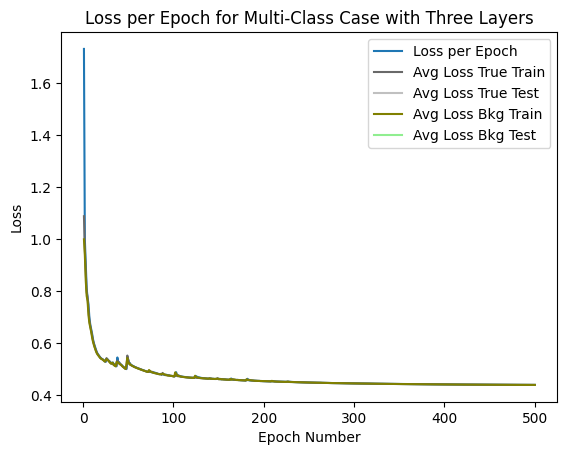

In [ ]:
plt.plot(epoch_number, lossPerEpoch, label='Loss per Epoch')
plt.plot(epoch_number, avgLoss_TrueTrain,
         'dimgray', label='Avg Loss True Train')
plt.plot(epoch_number, avgLoss_TrueTest, 'silver', label='Avg Loss True Test')
plt.plot(epoch_number, avgLoss_BkgTrain, 'olive', label='Avg Loss Bkg Train')
plt.plot(epoch_number, avgLoss_BkgTest,
         'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Multi-Class Case with Three Layers")
plt.legend()
plt.show()

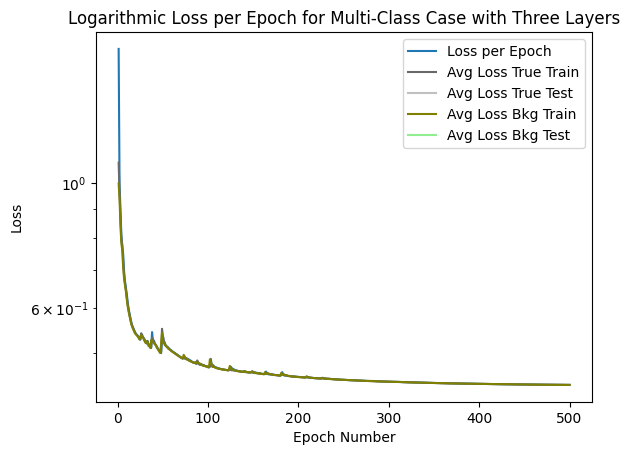

In [ ]:
plt.plot(epoch_number, lossPerEpoch, label='Loss per Epoch')
plt.plot(epoch_number, avgLoss_TrueTrain,
         'dimgray', label='Avg Loss True Train')
plt.plot(epoch_number, avgLoss_TrueTest, 'silver', label='Avg Loss True Test')
plt.plot(epoch_number, avgLoss_BkgTrain, 'olive', label='Avg Loss Bkg Train')
plt.plot(epoch_number, avgLoss_BkgTest,
         'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Logarithmic Loss per Epoch for Multi-Class Case with Three Layers")
plt.legend()
plt.show()

In [82]:
def plotROCCurve(epoch_scores, epoch_truth_labels, epoch_number):
    # Generate binary labels where 1 represents the true class (class 1), and 0 represents all background classes (0, 2, 3, 4)
    binary_labels = (epoch_truth_labels == 1).astype(int)

    # Extract scores for the true class (first column in `epoch_scores`, class 1)
    true_class_scores = epoch_scores[:, 0]

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(binary_labels, true_class_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Epoch " + str(epoch_number))
    plt.show()

In [83]:
# Epoch numbers for plot labels
epoch_number = list(range(1, len(lossPerEpoch) + 1))

# Define custom class labels with the new mapping
class_labels = ["Lone-Lone", "True Cluster",
                "Lone-Cluster", "Cluster-Lone", "Cluster-Cluster"]

# Function to plot ROC curve for multiclass classification with custom labels


def plotROCCurveMulticlass(epoch_scores, epoch_truth_labels, epoch_number, num_classes=5):
    plt.figure()

    # Define the class order: True class first, then background classes
    class_order = [1, 0, 2, 3, 4]

    # Iterate over each class in the custom order and compute the ROC curve
    for plot_idx, class_idx in enumerate(class_order):
        # Convert truth labels to one-vs-all format (1 for current class, 0 for all others)
        binary_truth_labels = (epoch_truth_labels == class_idx).astype(int)

        # Get the predicted probabilities/scores for the current class
        # scores for the current class
        class_scores = epoch_scores[:, class_idx]

        # Compute the ROC curve
        fpr, tpr, _ = roc_curve(binary_truth_labels, class_scores)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class with a custom label
        plt.plot(
            fpr, tpr, label=f'{class_labels[plot_idx]} (AUC = {roc_auc:.3f})')

    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Epoch {epoch_number}")
    plt.show()

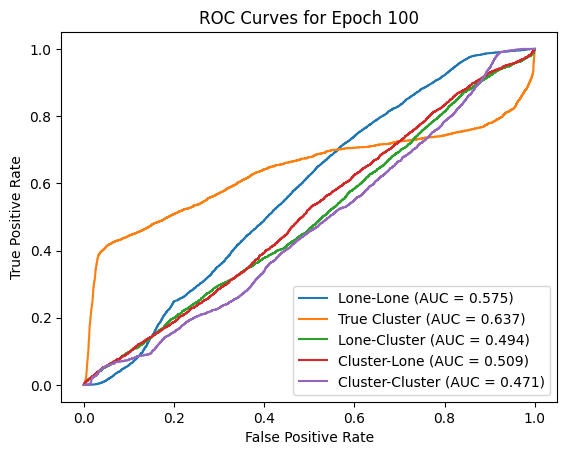

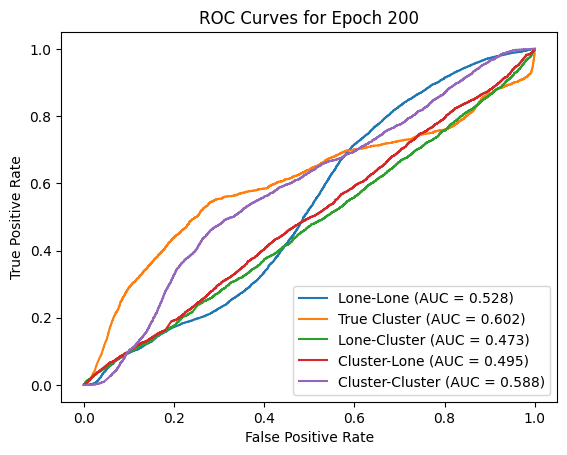

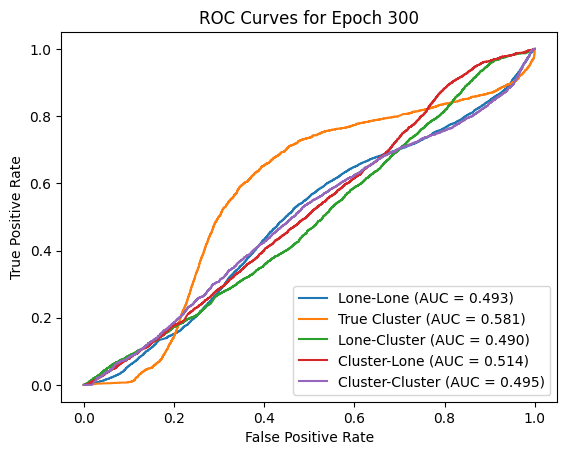

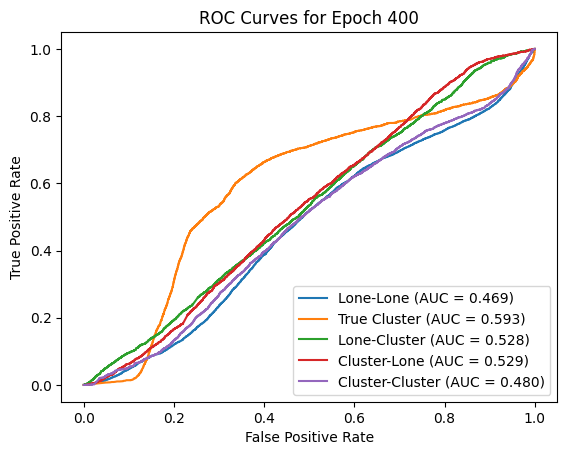

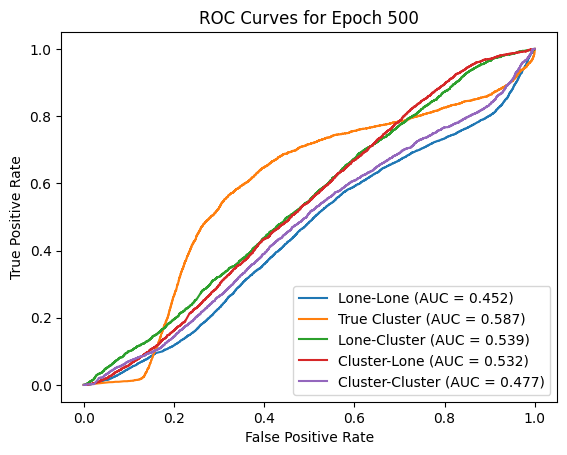

In [84]:
# Total number of epochs
epochNum = 1000
intervalShowingROCGraph = epochNum // 10  # every 100 epochs

# Plot ROC curves at specific intervals with custom labels
for i in range(0, epochNum//2):
    if (i+1) % intervalShowingROCGraph == 0:
        plotROCCurveMulticlass(scores[i], truth_labels[i], i+1)

In [85]:
# Reshape scores and labels to flatten across epochs
flattened_scores = scores.reshape(-1, 5)  # Shape (500 * 24000, 5)
flattened_labels = truth_labels.flatten()  # Shape (500 * 24000,)

# Get the unique class labels to identify the order
unique_classes = np.unique(flattened_labels)  # array([0, 1, 2, 3, 4])

# Initialize a dictionary to store probabilities for each class
class_probabilities = {cls: [] for cls in unique_classes}

# Group scores by class
for cls in unique_classes:
    class_mask = flattened_labels == cls  # Boolean mask for current class
    # Scores for this class
    class_probabilities[cls] = flattened_scores[class_mask, cls]

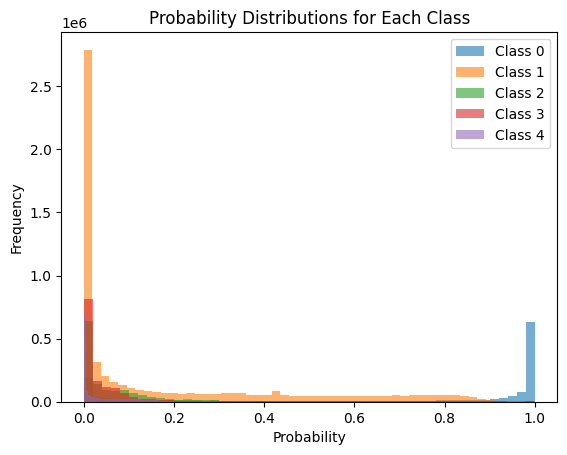

In [ ]:
# Plot distributions for each class
for cls, probabilities in class_probabilities.items():
    plt.hist(probabilities, bins=50, alpha=0.6, label=f'Class {cls}')

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distributions for Each Class')
plt.legend()
plt.show()

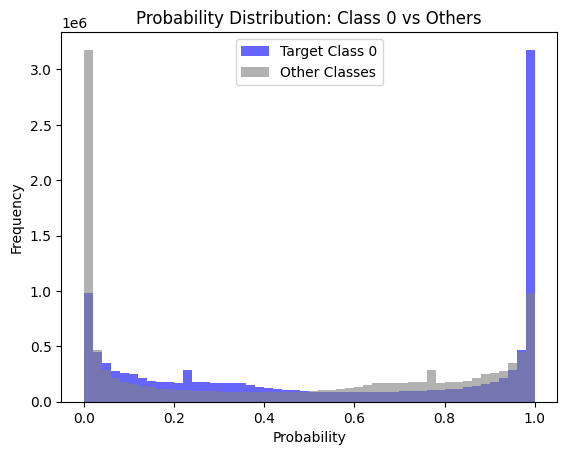

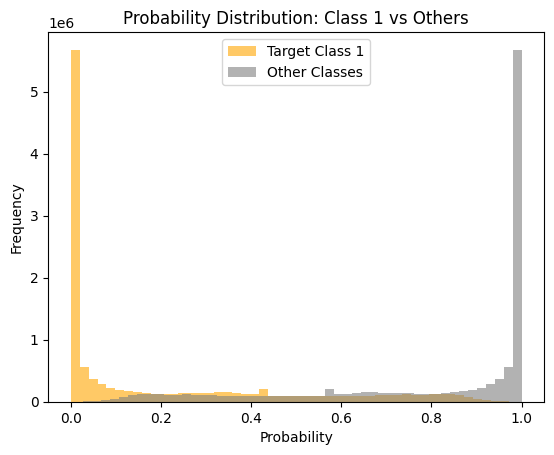

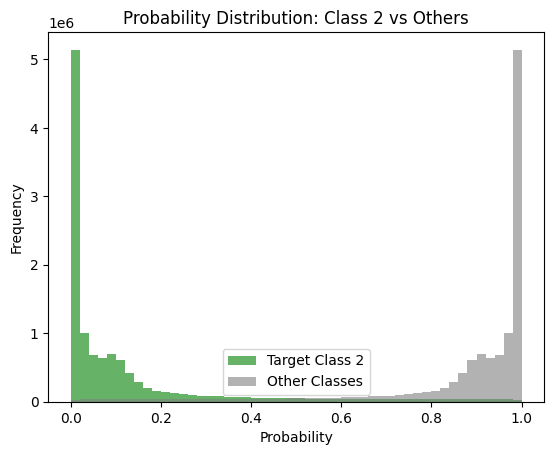

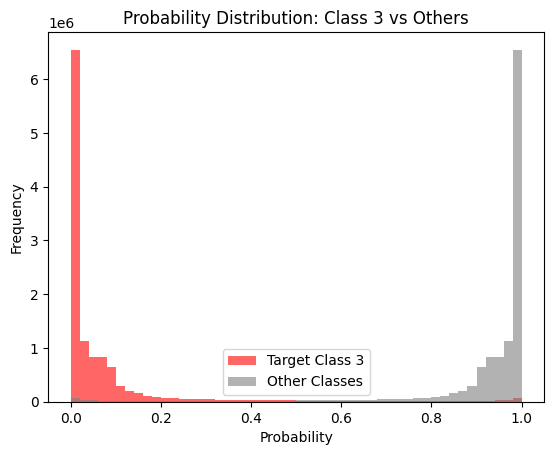

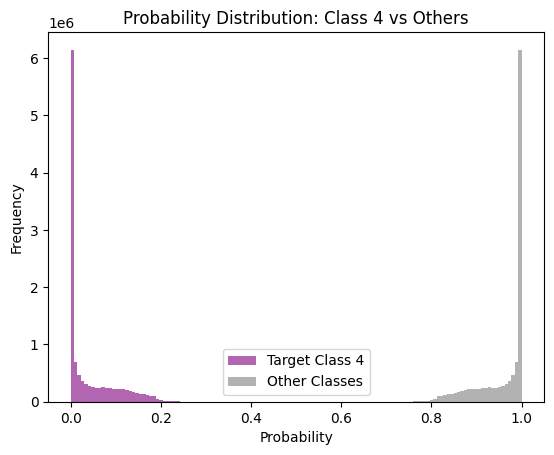

In [ ]:
# Class colors
class_colors = ['blue', 'orange', 'green', 'red', 'purple']

# Number of classes in the dataset
num_classes = flattened_scores.shape[1]

for target_class in range(num_classes):
    # Extract probabilities for the target class
    target_class_probs = flattened_scores[:, target_class]

    # Calculate probabilities for all other classes
    other_classes_indices = [i for i in range(
        num_classes) if i != target_class]
    other_classes_probs = np.sum(
        flattened_scores[:, other_classes_indices], axis=1)

    # Plot distributions
    plt.hist(target_class_probs, bins=50, alpha=0.6,
             label=f'Target Class {target_class}', color=class_colors[target_class])
    plt.hist(other_classes_probs, bins=50, alpha=0.6,
             label='Other Classes', color='grey')

    # Add labels, title, and legend
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(f'Probability Distribution: Class {target_class} vs Others')
    plt.legend()
    plt.show()

In [98]:
# make a cmatrix  - threshold 0.5 as a start for each plot
threshold = 0.5

# Store the confusion matrices in a list
cmatrices = []

# Comparing the predicted class with the true class
for epoch in range(500):
    # Extract labels and scores for given epoch
    epoch_score = scores[epoch]
    epoch_label = truth_labels[epoch]

    # Determine prediction with a given threshold value
    preds = (epoch_score > threshold).astype(int)
    max_prob_classes = np.argmax(epoch_score, axis=1)
    predictions = np.where(np.any(preds, axis=1), max_prob_classes, 0)

    # Compute confusion matrix
    cm = confusion_matrix(epoch_true_labels, predictions,
                          labels=[0, 1, 2, 3, 4])
    cmatrices.append(cm)

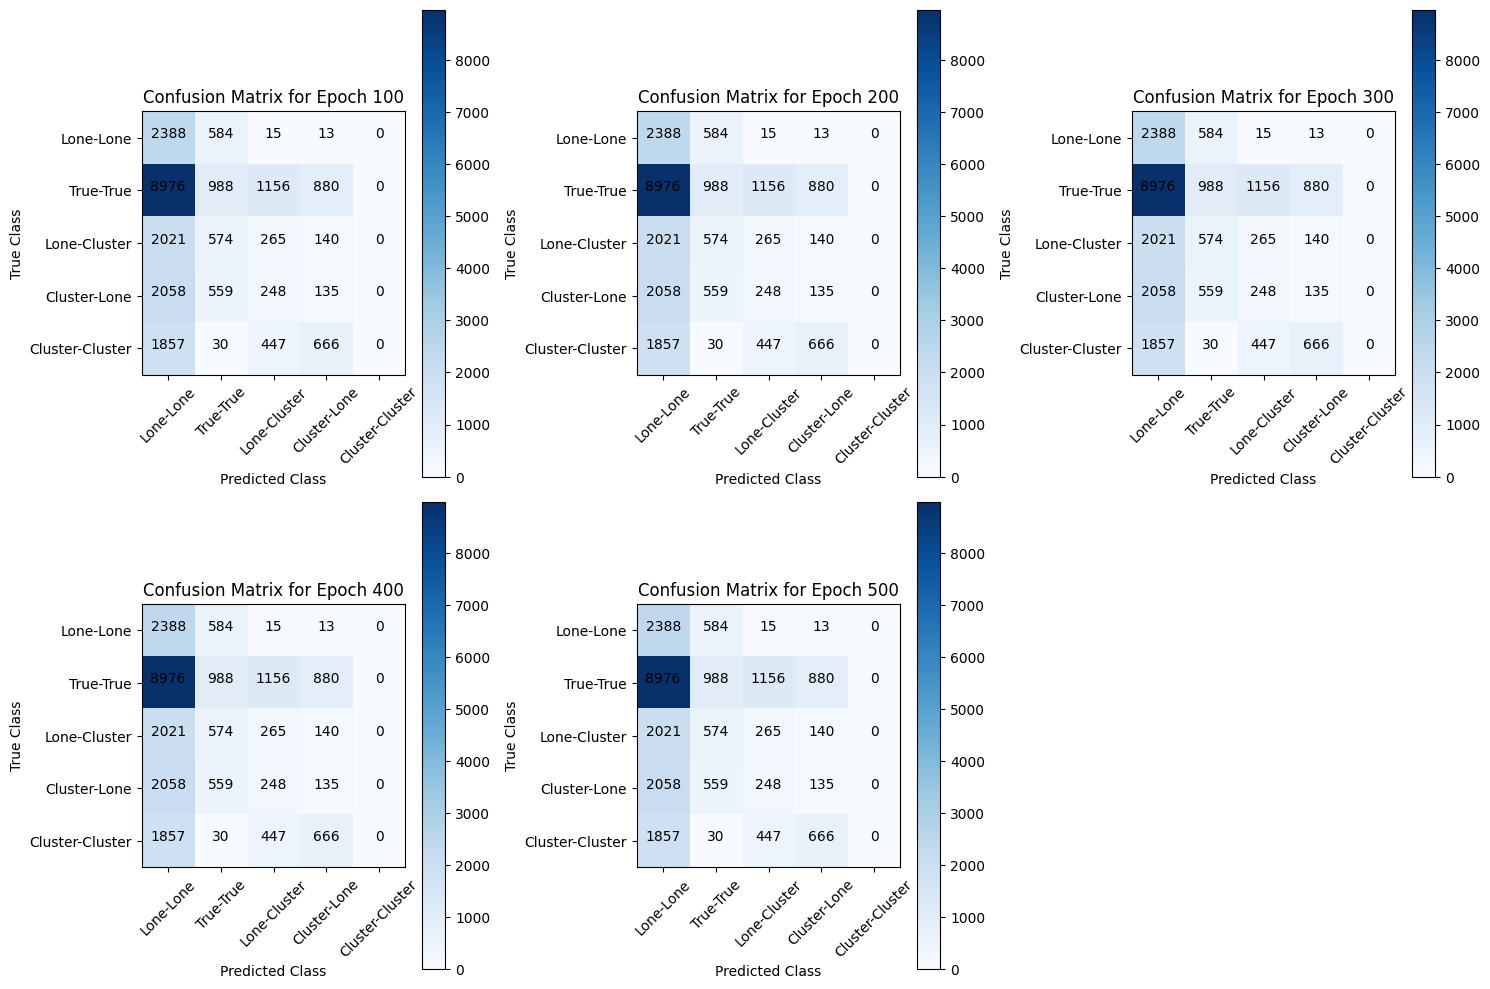

In [100]:
# Function to plot a confusion matrix using plt only
def plot_confusion_matrix_with_plt(cm, epoch, class_labels):
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix for Epoch {epoch}')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    # Annotate cells
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center", color="black")

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()


# Class labels
class_labels = ['Lone-Lone', 'True-True',
                'Lone-Cluster', 'Cluster-Lone', 'Cluster-Cluster']

# Plot confusion matrices for specific epochs
epochs_to_plot = [100, 200, 300, 400, 500]
plt.figure(figsize=(15, 10))

for idx, epoch in enumerate(epochs_to_plot, start=1):
    cm = cmatrices[- 1]  # Adjusting for 0-based indexing
    plt.subplot(2, 3, idx)  # Create a grid of subplots
    plot_confusion_matrix_with_plt(cm, epoch, class_labels)

plt.tight_layout()
plt.show()

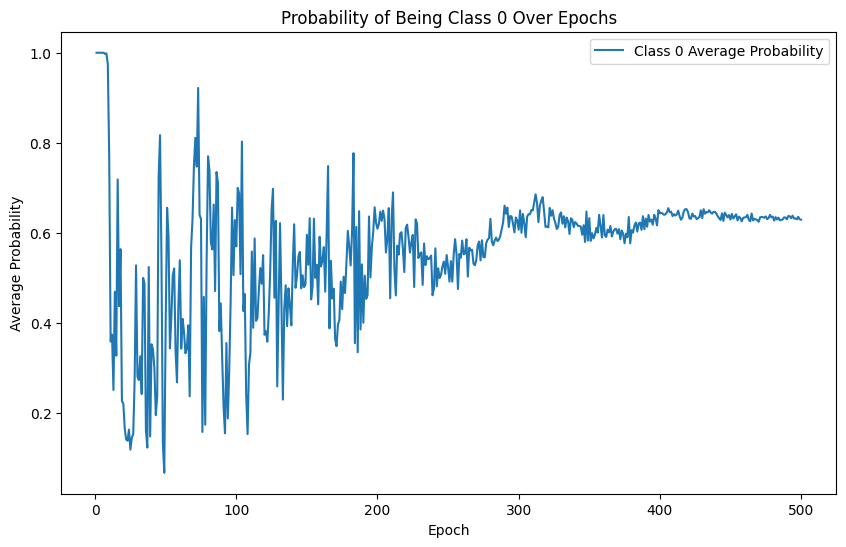

In [111]:
class_choice = 0

# Extract probabilities for the chosen class across all epochs
class_probabilities = scores[:, :, class_choice]
plt.figure(figsize=(10, 6))

# Average probabilities over all samples for each epoch
avg_probabilities = np.mean(class_probabilities, axis=1)

# Plot the average probabilities across epochs
plt.plot(range(1, 501), avg_probabilities,
         label=f'Class {class_choice} Average Probability')

# Add labels and title
plt.title(f'Probability of Being Class {class_choice} Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Probability')
plt.legend()
plt.show()

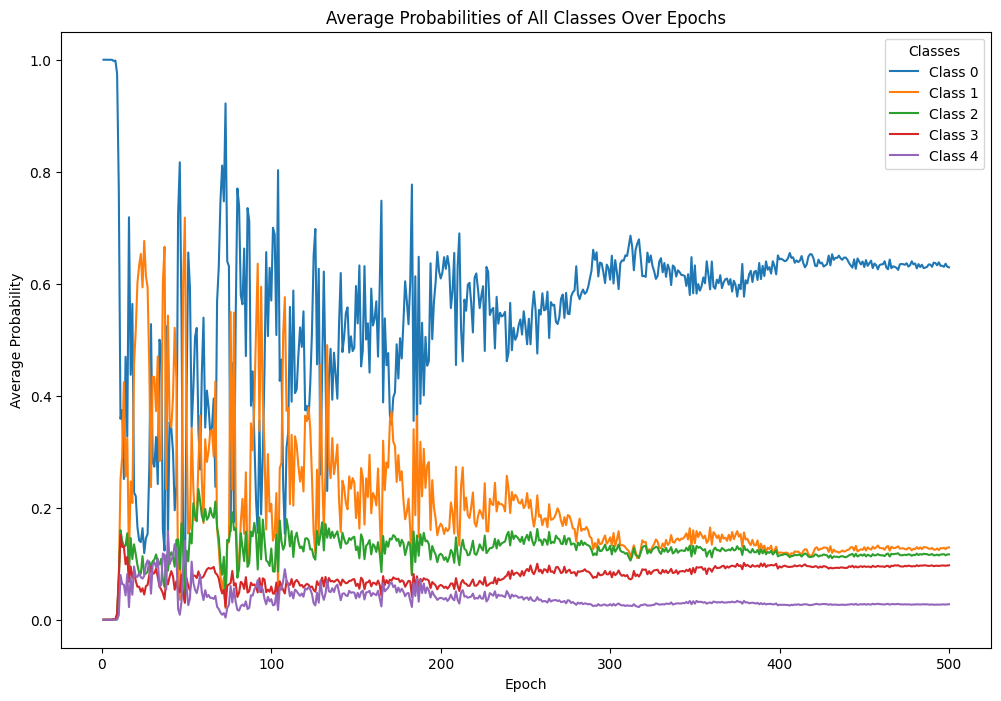

In [110]:
num_classes = 5

# Plot probabilities for all classes
plt.figure(figsize=(12, 8))

for class_choice in range(num_classes):
    # Extract probabilities for the current class across all epochs
    class_probabilities = scores[:, :, class_choice]  # Shape: (500, 24000)

    # Average probabilities over all samples for each epoch
    avg_probabilities = np.mean(class_probabilities, axis=1)

    # Plot the average probabilities across epochs for the current class
    plt.plot(range(1, 501), avg_probabilities, label=f'Class {class_choice}')

# Add labels, title, and legend
plt.title('Average Probabilities of All Classes Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Probability')
plt.legend(title="Classes")
plt.show()